This has the same content as the simple_model_synthetc_data.py file, but it is moved into a notebook so that it is easier & more intuitive to perform data analysis on.

In [7]:
# imports
import argparse
from argparse import Namespace

from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# define checkpoints for the model
# tells it when to save snapshots of the model during training
# Callback to save the best model based on validation loss
best_model_checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Callback to save checkpoints every 5 epochs, regardless of performance
periodic_checkpoint = ModelCheckpoint(
    filename="periodic-{epoch:02d}",
    every_n_epochs=2,
    save_top_k=-1,  # Setting -1 saves all checkpoints
)

In [9]:
# configure loggers
tb_logger = TensorBoardLogger("logs/tensorboard_logs")
csv_logger = CSVLogger("logs/csv_logs")

Note that the experiment below will also save logs and checkpoints to the experiments/logs directory

In [10]:
from torchsummary import summary
def simple_model_synthetic_data_experiment(
    batch_size: int,
    lr: float,
    max_epochs: int,
    using_random_seed: bool,
    accelerator: str,
    num_genes: int,
    signal_mean: float,
    val_size: float,
    test_size: float,
    signal: list[float],
    n_sample: list[int],
) -> LightningModule:
    """
    Trains a SimpleModel on synthetic data and saves the best model based on validation
    loss. Defines an instance of Trainer, which is used to train the model with the
    given dataModule. While much of the training process is captured via logging, we
    also print the test results at the end of training. We don't need to do assrtions
    for type checking, as this was done in the parse_args_for_synthetic_data_experiment
    function.

    :param batch_size: The batch size to use for training
    :type batch_size: int
    :param lr: The learning rate to use for training
    :type lr: float
    :param max_epochs: The maximum number of epochs to train for
    :type max_epochs: int
    :param using_random_seed: Whether or not to use a random seed for reproducibility
    :type using_random_seed: bool
    :param accelerator: The accelerator to use for training (e.g. 'gpu', 'cpu')
    :type accelerator: str
    :param num_genes: The number of genes to generate synthetic data for (rows of matrix)
    :type num_genes: int
    :param signal_mean: The mean of the signal to use for generating synthetic data
    :type signal_mean: float
    :param val_size: The proportion of the data to use for validation
    :type val_size: float
    :param test_size: The proportion of the data to use for testing
    :type test_size: float
    :param signal: The percentage of each sample to put in the signal group
    :type signal: list[float]
    :param n_sample: The number of samples to generate for each signal group, the sum of which is the number of TFs
    :type n_sample: list[int]

    """

    data_module = SyntheticDataLoader(
        batch_size=batch_size,
        num_genes=num_genes,
        signal_mean=signal_mean,
        signal=signal,  # old: [0.1, 0.15, 0.2, 0.25, 0.3],
        n_sample=n_sample,  # sum of this is num of tfs
        val_size=val_size,
        test_size=test_size,
        random_state=42,
    )

    num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs

    model = SimpleModel(input_dim=num_tfs, output_dim=num_tfs, lr=lr)
    trainer = Trainer(
        max_epochs=max_epochs,
        deterministic=using_random_seed,
        accelerator=accelerator,
        callbacks=[best_model_checkpoint, periodic_checkpoint],
        logger=[tb_logger, csv_logger],
    )
    trainer.fit(model, data_module)

    test_results = trainer.test(model, datamodule=data_module)
    print("Printing test results...")
    print(
        test_results
    )  # this prints all metrics that were logged during the test phase

    # print summary of model
    print("Printing model summary...")
    summary(model, (num_tfs, num_tfs)) 

    return model, test_results

In [11]:
# Set values and run the experiment
seed_everything(42)
simple_model_synthetic_data_experiment(
    batch_size=32,
    lr=0.01,
    max_epochs=10,
    using_random_seed=True,
    accelerator="cpu",
    num_genes=1000,
    val_size=0.1,
    test_size=0.1,
    signal=[0.5] * 5,  # old: [0.1, 0.15, 0.2, 0.25, 0.3],   # [0.5] * 5
    n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs   # [1, 1, 2, 2, 4]
    signal_mean=3.0
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/Br

bm - creating perturbation effects list with signal_mean: 3.0
bm - also signal is  [0.5, 0.5, 0.5, 0.5, 0.5]
bm - and also n_sample is  [1, 1, 2, 2, 4]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


bm - creating perturbation effects list with signal_mean: 3.0
bm - also signal is  [0.5, 0.5, 0.5, 0.5, 0.5]
bm - and also n_sample is  [1, 1, 2, 2, 4]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           10.104333877563477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_loss': 10.104333877563477}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------

(SimpleModel(
   (linear1): Linear(in_features=10, out_features=10, bias=True)
 ),
 [{'test_loss': 10.104333877563477}])

Experiment to see how the mse changes as a function of the signal mean

In [ ]:
# little experiment to see how the mse changes as a function of the signal mean
signal_means = [0.5, 1.0, 2.0, 3.0, 5.0, 10.0]
mse = []
for signal_mean in signal_means:
    model, test_results = simple_model_synthetic_data_experiment(
        batch_size=32,
        lr=0.01,
        max_epochs=10,
        using_random_seed=True,
        accelerator="cpu",
        num_genes=1000,
        val_size=0.1,
        test_size=0.1,
        signal=[0.5] * 5,  # old: [0.1, 0.15, 0.2, 0.25, 0.3],   # [0.5] * 5
        n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs    # [1, 1, 2, 2, 4]
        signal_mean=signal_mean  # this is the perturb effect signal mean
    )
    print(test_results)
    mse.append(test_results[0]["test_loss"])

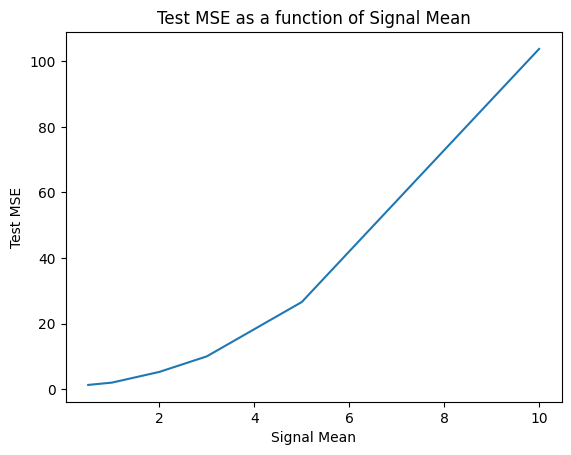

In [ ]:
# plottig results of experiment
plt.plot(signal_means, mse)
plt.xlabel("Signal Mean")
plt.ylabel("Test MSE")
plt.title("Test MSE as a function of Signal Mean")
plt.show()